# Recognizing hand gestures from EMG signal

This notebook includes the pooling and tidying of the data from the paper **Latent Factors Limiting the Performance of sEMG-Interfaces** [Lobov et al., (2018)](https://www.mdpi.com/1424-8220/18/4/1122).


## Imports

In [1]:
import re
import os
import glob
import requests
import shutil

import numpy as np
import pandas as pd

np.random.seed(999)

### Defining helper functions


In [13]:
def root_mean_square(s: np.array) -> np.array:
    return np.sqrt(np.mean(np.power(s, 2)))

def mean_abs_val(s: np.array) -> np.array:
    return np.mean(np.abs(s))

def prep_single_df(fname: str) -> pd.DataFrame:
    _df = pd.read_csv(fname, sep='\t')
    data_info = re.findall(r'\d+', fname)
    subject, session = data_info[:2]
    timestamp = data_info[2:]
    _df = _df.assign(subject=subject, session=session)
    return _df

## Loading the dataset

Download the dataset (a zip folder) into the current directory

In [7]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00481/EMG_data_for_gestures-master.zip'
zip_data_path = f"../{url.split('/')[-1]}"

with requests.get(url, stream=True) as r:
    with open(zip_data_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

Extract the dataset into a new folder, and remove the zip file.

In [8]:
!dir ..

 Volume in drive G is eitan.hemed@gmail.com - Googl...
 Volume Serial Number is 1983-1116

 Directory of G:\My Drive\OneDrive Transfer\Postdoc\Projects\emg_gestures

08/17/2023  02:05 AM    <DIR>          .
08/17/2023  02:02 AM    <DIR>          ..
08/17/2023  02:03 AM    <DIR>          .idea
08/16/2023  11:16 PM               431 pyproject.toml
06/28/2023  04:44 PM                39 setup.py
08/17/2023  01:58 AM               438 README.md
08/17/2023  12:45 AM               140 env.yml
08/17/2023  02:05 AM    <DIR>          notebooks
08/17/2023  02:05 AM        17,699,840 EMG_data_for_gestures-master.zip
               5 File(s)     17,700,888 bytes
               4 Dir(s)  211,908,984,832 bytes free


In [9]:
shutil.unpack_archive(zip_data_path, '..')
os.rename(os.path.splitext(zip_data_path)[0], '../input-data')
os.remove(zip_data_path)

In [10]:
# Print the description of the dataset
!cat ../input-data/README.txt

EMG Pattern Database

For recording patterns, we used a MYO Thalmic bracelet worn on a user’s forearm, and a PC with a Bluetooth receiver. The bracelet is equipped with eight sensors equally spaced around the forearm that simultaneously acquire myographic signals. The signals are sent through a Bluetooth interface to a PC. 
We present raw EMG data for 36 subjects while they performed series of static hand gestures.The subject performs two series, each of which consists of six (seven) basic gestures. Each gesture was performed for 3 seconds with a pause of 3 seconds between gestures.


Description of raw_data _*** file
Each file consist of 10 columns:
1) Time - time in ms;
2-9) Channel - eightEMG channels of MYO Thalmic bracelet;
10) Class  –thelabel of gestures: 
0 - unmarked data,
1 - hand at rest, 
2 - hand clenched in a fist, 
3 - wrist flexion,
4 – wrist extension,
5 – radial deviations,
6 - ulnar deviations,
7 - extended palm (the gesture was not performed by all subjects).




Re

## Pool the data into a single dataframe

In [11]:
raw_data_file_paths = glob.glob('../input-data/*/*.txt')

In [24]:
df = pd.concat([prep_single_df(fname) for fname in raw_data_file_paths],
                ignore_index=True).rename({'class': 'gesture', 'time': 'session_sample_idx'}, axis=1)

## Wrangling and tidying

Partition each session into trials, where on each trial a different gesture is performed.

In [25]:
# Finding trial onsets is the matter of finding a difference in the performed gesture
df['first_frame_on_trial'] = df['gesture'].diff().ne(0)
df['first_frame_on_trial'] = df['first_frame_on_trial'].replace(
    {True: 1, False: np.nan})

onsets = df.loc[df['first_frame_on_trial'].notna()]
numof_onsets = onsets.shape[0]

# Assign trial numbers to each onset
df.loc[onsets.index.values, 'trial_num'] = np.concatenate(
    onsets.groupby(['subject', 'session']).apply(lambda s: np.arange(s.shape[0])).values)
# Forward fill the trial numbers
df['trial_num'] = df['trial_num'].ffill().values.astype(int)

df = df.drop('first_frame_on_trial', axis=1)

Mark the sample index within each trial, to be used later for aggregating the data into 200ms bins

In [26]:
df['trial_sample_idx'] = df.groupby(['subject', 'session', 'trial_num'])['session_sample_idx'].transform(
    lambda s: s - s.min())

## Exploration

Subject and session are represented as strings, but they should be integers

In [27]:
df.dtypes.tail()

gesture             float64
subject              object
session              object
trial_num             int32
trial_sample_idx      int64
dtype: object

In [28]:
df[['subject', 'session']] = df[['subject', 'session']].astype(int)

Some subjects have more than 7 different gestures, which is not expected

In [29]:
df.groupby('subject')['gesture'].nunique().value_counts()

gesture
7    34
8     2
Name: count, dtype: int64

We can either remove them, or remove the periods with the extra gesture, either way, here are their subject and session IDs.

In [30]:
df.groupby(['subject', 'session'])['gesture'].nunique().reset_index(
    ).rename({'gesture': 'numof_classes'}, axis=1).query(
    'numof_classes > 7')

,subject,session,numof_classes
20,11,1,8
21,11,2,8
58,30,1,8
59,30,2,8


There is some unmarked data for one subject and session.

In [32]:
df.loc[df['gesture'].isna(), ['subject', 'session']].head()

,subject,session
3985214,34,1


Subjects train on each gesture, with rest intervals in between.

[Text(0.5, 0, 'Sample Index'), Text(0, 0.5, 'Gesture #')]

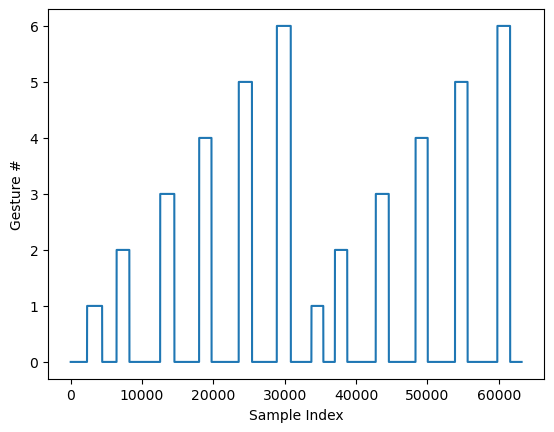

In [35]:
ax = df.loc[(df['subject'] == 1) & (df['session'] == 1), 'gesture'].plot()
ax.set(xlabel='Sample Index', ylabel='Gesture #')

## Feature engineering

Common EEG features are root-mean-square and mean-absolute-value, calculated on each value. Here they are calculated per trial, we can also calculate them per period (200MS) within each trial.

In [37]:
agg_args = {k: [root_mean_square, mean_abs_val] for k in df.filter(regex='channel\d$').columns}

aggregated_df = df.groupby(['subject', 'session', 'trial_num'])[
    list(agg_args.keys())].agg(
    agg_args)

Accessing the Multindex

In [39]:
aggregated_df.head().loc[(1, 1, 0), 'channel1']

root_mean_square    0.000015
mean_abs_val        0.000011
Name: (1, 1, 0), dtype: float64